In [63]:
!pip install git+https://github.com/openai/point-e -q
!pip install pandas -q
!pip install open3d -q
!pip install numpy-stl -q
!pip install trimesh -q
import trimesh

from stl import mesh, stl
import pandas as pd
import open3d as o3d
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/openai/point-e /tmp/pip-req-build-u5abn5k1 did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/openai/point-e /tmp/pip-req-build-u5abn5k1 did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [65]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096-1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [66]:
# Set a prompt to create a point cloud from.
prompt = 'an orangutang'

# Produce the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

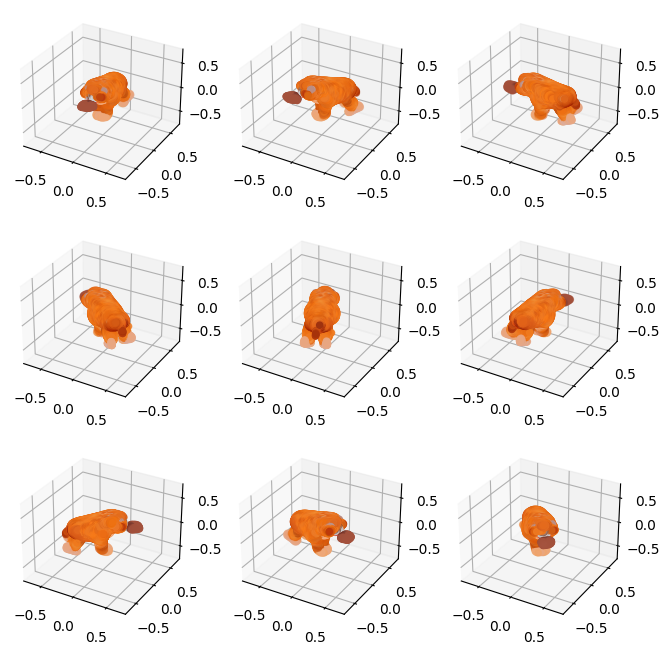

In [67]:
pc = sampler.output_to_point_clouds(samples)[0]
pc.save('pointcloud.npz')
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [88]:
# Convert the point cloud into a mesh.
import open3d as o3d

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=128, # increase to 128 for resolution used in evals
    progress=True,
)

creating SDF model...
loading SDF model...


  0%|          | 0/512 [00:00<?, ?it/s]

In [93]:
# Convert the mesh.ply into an stl after decimating

!pip install open3d -q
import open3d as o3d
# Load the mesh using Open3D
o3d_mesh = o3d.io.read_triangle_mesh('mesh.ply')

# Simplify the mesh using quadric decimation
decimation_target_number_of_triangles = int(0.01 * len(o3d_mesh.triangles))  # Decimate to 50% of original triangles. Adjust as needed.
simplified_mesh = o3d_mesh.simplify_quadric_decimation(decimation_target_number_of_triangles)

# Compute the normals for the simplified mesh
simplified_mesh.compute_vertex_normals()

# Convert the simplified mesh back to STL
o3d.io.write_triangle_mesh('simplified_output_mesh.stl', simplified_mesh)

print('done')

done


In [94]:
# Finally convert the decimated STL into an ASCII stl

# Load the simplified mesh with trimesh
simplified_mesh_trimesh = trimesh.load('simplified_output_mesh.stl')

# Export the mesh to STL in ASCII format
simplified_mesh_trimesh.export(file_obj='ascii_simplified_output_mesh.stl', file_type='stl_ascii')

print('done')

done
